# Detección de Incendios utilizando CNNs

In [17]:
!pip install torch torchvision datasets transformers matplotlib pandas scikit-learn pillow tqdm

!pip install --upgrade datasets


!!pip install kagglehub





[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


['Collecting kagglehub',
 '  Downloading kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)',
 'Requirement already satisfied: packaging in c:\\users\\nicol\\desktop\\proyecto fdap\\venv\\lib\\site-packages (from kagglehub) (25.0)',
 'Requirement already satisfied: pyyaml in c:\\users\\nicol\\desktop\\proyecto fdap\\venv\\lib\\site-packages (from kagglehub) (6.0.3)',
 'Requirement already satisfied: requests in c:\\users\\nicol\\desktop\\proyecto fdap\\venv\\lib\\site-packages (from kagglehub) (2.32.5)',
 'Requirement already satisfied: tqdm in c:\\users\\nicol\\desktop\\proyecto fdap\\venv\\lib\\site-packages (from kagglehub) (4.67.1)',
 'Requirement already satisfied: charset_normalizer<4,>=2 in c:\\users\\nicol\\desktop\\proyecto fdap\\venv\\lib\\site-packages (from requests->kagglehub) (3.4.4)',
 'Requirement already satisfied: idna<4,>=2.5 in c:\\users\\nicol\\desktop\\proyecto fdap\\venv\\lib\\site-packages (from requests->kagglehub) (3.11)',
 'Requirement already satisfied: urll

In [32]:
# ===============================
# Importaciones
# ===============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor

import datasets

from datasets import load_dataset

import collections


import torchvision.models as models
import torch.nn as nn



from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

device = "cuda" if torch.cuda.is_available() else "cpu"



In [4]:

DATASET_DIR = r"D:\DATASET_FDAP_MODELOS\dataset\the_wildfire_dataset_2n_version"


In [13]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.resize((1024, 1024)) if img.size[0] * img.size[1] > 89478485 else img),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



train_ds = datasets.ImageFolder(os.path.join(DATASET_DIR, "train"), transform=transform)
val_ds   = datasets.ImageFolder(os.path.join(DATASET_DIR, "val"), transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print ("DATOS CLASE DE ENTRENAMIENTO")
print("=================================")
print("CLASES:", train_ds.classes)
print("Cantidad de imágenes:")
print("Train:", len(train_ds))
print("Val:",   len(val_ds))
print("Test:",  len(test_ds))
print("=================================")
print("DATOS CLASE DE TESTEO")
print("=================================")
print("CLASES:", test_ds.classes)
print("Cantidad de imágenes:")
print("Test:",  len(test_ds))
print("=================================")  
print("DATOS CLASE DE VALIDACION")
print("=================================")
print("CLASES:", val_ds.classes)
print("Cantidad de imágenes:")
print("Val:",  len(val_ds))
print("=================================")



DATOS CLASE DE ENTRENAMIENTO
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Train: 1887
Val: 402
Test: 410
DATOS CLASE DE TESTEO
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Test: 410
DATOS CLASE DE VALIDACION
CLASES: ['fire', 'nofire']
Cantidad de imágenes:
Val: 402


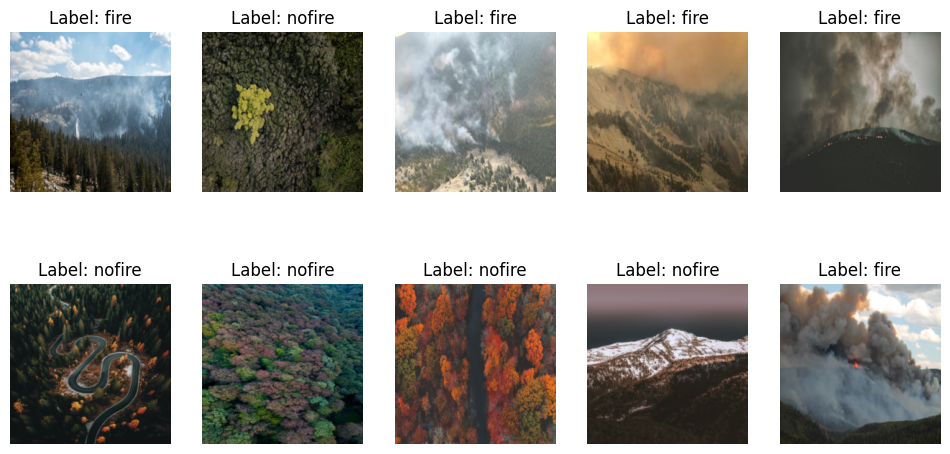

In [14]:
def show_random_images(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(f"Label: {dataset.classes[label]}")
        plt.axis("off")
    plt.show()


show_random_images(train_ds, n=10)


In [15]:


train_counts = collections.Counter([label for _, label in train_ds])
val_counts   = collections.Counter([label for _, label in val_ds])
test_counts  = collections.Counter([label for _, label in test_ds])

print("Distribución Train:", train_counts)
print("Distribución Val:", val_counts)
print("Distribución Test:", test_counts)


Distribución Train: Counter({1: 1157, 0: 730})
Distribución Val: Counter({1: 246, 0: 156})
Distribución Test: Counter({1: 251, 0: 159})


In [16]:
MODEL_DIR = r"D:\DATASET_FDAP_MODELOS\Modelos"
os.makedirs(MODEL_DIR, exist_ok=True)

In [25]:


def load_efficientnet(model_name="google/efficientnet-b0", num_labels=2):
    model_folder = os.path.join(MODEL_DIR, model_name.split("/")[-1])
    os.makedirs(model_folder, exist_ok=True)

    print(f"Cargando {model_name} en {model_folder} ...")

    # AutoImageProcessor
    processor = AutoImageProcessor.from_pretrained(model_name, cache_dir=model_folder)
    
    # Cargar modelo preentrenado tal cual (1000 clases)
    model = AutoModelForImageClassification.from_pretrained(
        model_name, cache_dir=model_folder
    )
    
    # Reemplazar la capa final con la cantidad de clases que necesitas
    in_features = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_features, num_labels)

    print(f"{model_name} cargado desde {model_folder}.")
    return model, processor

# Función para descargar y/o cargar un modelo torchvision
def load_torchvision_model(model_name="mobilenet_v3_small", num_labels=2):
    file_path = os.path.join(MODEL_DIR, f"{model_name}.pth")
    
    if os.path.exists(file_path):
        print(f"Cargando {model_name} desde {file_path} ...")
        if model_name == "mobilenet_v3_small":
            model = models.mobilenet_v3_small(pretrained=False)
            model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=False)
            model.fc = nn.Linear(model.fc.in_features, num_labels)
        else:
            raise ValueError("Modelo no soportado")
        model.load_state_dict(torch.load(file_path))
    else:
        print(f"Descargando y guardando {model_name} en {file_path} ...")
        if model_name == "mobilenet_v3_small":
            model = models.mobilenet_v3_small(pretrained=True)
            model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, num_labels)
        else:
            raise ValueError("Modelo no soportado")
        torch.save(model.state_dict(), file_path)
    
    print(f"{model_name} listo para usar.")
    return model

In [26]:
# 1️⃣ EfficientNet-B0
efficientnet_b0, extractor_b0 = load_efficientnet("google/efficientnet-b0")

# 2️⃣ EfficientNet-B5
#efficientnet_b5, extractor_b5 = load_efficientnet("google/efficientnet-b5")

# 3️⃣ MobileNetV3-Small
#mobilenet = load_torchvision_model("mobilenet_v3_small")

# 4️⃣ ResNet50
#resnet50 = load_torchvision_model("resnet50")

Cargando google/efficientnet-b0 en D:\DATASET_FDAP_MODELOS\Modelos\efficientnet-b0 ...
google/efficientnet-b0 cargado desde D:\DATASET_FDAP_MODELOS\Modelos\efficientnet-b0.


In [27]:
efficientnet_b5, extractor_b5 = load_efficientnet("google/efficientnet-b5")

Cargando google/efficientnet-b5 en D:\DATASET_FDAP_MODELOS\Modelos\efficientnet-b5 ...


preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\DATASET_FDAP_MODELOS\Modelos\efficientnet-b5\models--google--efficientnet-b5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/123M [00:00<?, ?B/s]

google/efficientnet-b5 cargado desde D:\DATASET_FDAP_MODELOS\Modelos\efficientnet-b5.


model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

In [28]:
mobilenet = load_torchvision_model("mobilenet_v3_small")

c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Descargando y guardando mobilenet_v3_small en D:\DATASET_FDAP_MODELOS\Modelos\mobilenet_v3_small.pth ...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\nicol/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 11.6MB/s]


mobilenet_v3_small listo para usar.


In [29]:
resnet50 = load_torchvision_model("resnet50")

Descargando y guardando resnet50 en D:\DATASET_FDAP_MODELOS\Modelos\resnet50.pth ...


c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nicol/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 11.5MB/s]


resnet50 listo para usar.


In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, device="cpu"):
    """
    Evalúa un modelo Hugging Face / PyTorch sobre un DataLoader.
    
    Args:
        model: modelo PyTorch o Hugging Face ya cargado
        dataloader: DataLoader con imágenes y etiquetas
        device: "cpu" o "cuda"
    
    Returns:
        accuracy (float), confusion_matrix (numpy array)
    """
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            # Para modelos Hugging Face, los logits están en outputs.logits
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, cm


In [35]:
# EfficientNet-B0
acc_b0, cm_b0 = evaluate_model(efficientnet_b0, train_loader, device=device)
print("EfficientNet-B0 - Train Accuracy:", acc_b0)
print("Confusion Matrix:\n", cm_b0)

# MobileNetV3-Small
acc_mn, cm_mn = evaluate_model(mobilenet, train_loader, device=device)
print("MobileNetV3-Small - Train Accuracy:", acc_mn)
print("Confusion Matrix:\n", cm_mn)

# ResNet50
acc_r50, cm_r50 = evaluate_model(resnet50, train_loader, device=device)
print("ResNet50 - Train Accuracy:", acc_r50)
print("Confusion Matrix:\n", cm_r50)

EfficientNet-B0 - Train Accuracy: 0.492845786963434
Confusion Matrix:
 [[599 131]
 [826 331]]


c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\PIL\Image.py:3432: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\PIL\Image.py:3432: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


MobileNetV3-Small - Train Accuracy: 0.566507684154743
Confusion Matrix:
 [[489 241]
 [577 580]]


c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\PIL\Image.py:3432: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\nicol\Desktop\Proyecto FDAP\venv\Lib\site-packages\PIL\Image.py:3432: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ResNet50 - Train Accuracy: 0.45204027556968734
Confusion Matrix:
 [[200 530]
 [504 653]]
